In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from category_encoders import MEstimateEncoder, TargetEncoder
from sklearn.inspection import permutation_importance

import seaborn as sns
import shap

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../lightgbm')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# File Paths
test_df_path = '../../Dataset/test.csv/test.csv'
process_train_path = './processed/processed_train_2.csv'
processed_test_path = './processed/processed_test_2.csv'
feats_path = './best_feats/Onehot_only_mean_NANs_modified_prices.csv'
output_path = './output/lgbm_pred_topFeat.csv'

modified_train = './processed/train.csv'

top_n = 75

In [3]:
# feats_df = pd.read_csv(feats_path)
# feats = feats_df['col_name'].values.tolist()[:top_n]
processed_df = pd.read_csv(process_train_path)
# processed_df = processed_df[feats+['price_doc']]
X = processed_df.drop(['price_doc'], axis=1)
y = processed_df['price_doc']
# X = X[feats]
modified_train_df = pd.read_csv(modified_train)

test_df = pd.read_csv(test_df_path)
processed_test_df = pd.read_csv(processed_test_path)
processed_test_df

id  full_sq    life_sq  floor  max_floor   build_year  num_room  \
0     30474    39.00  20.700000      2          9  1998.000000         1   
1     30475    79.20  34.404467      8         17     0.000000         3   
2     30476    40.50  25.100000      3          5  1960.000000         2   
3     30477    62.80  36.000000     17         17  2016.000000         2   
4     30478    40.00  40.000000     17         17     0.000000         1   
...     ...      ...        ...    ...        ...          ...       ...   
7657  38131    52.20  31.800000     10         12  1973.000000         2   
7658  38132    54.09  34.404467     14          0  1879.046638         2   
7659  38133    41.08   1.000000     12          1     1.000000         1   
7660  38134    34.80  19.800000      8          9  1977.000000         1   
7661  38135    63.00  43.800000      5          5  1973.000000         3   

      kitch_sq     state        area_m  ...  big_road1_1line_yes  \
0          8.9  3.000000  2.615514e+07  ...                  0.0   
1          1.0  1.000000  2.553630e+07  ...                  0.0   
2          4.8  2.000000  9.946335e+06  ...                  0.0   
3         62.8  3.000000  2.149409e+07  ...                  0.0   
4          1.0  1.000000  2.553630e+07  ...                  0.0   
...        ...       ...           ...  ...                  ...   
7657       9.1  2.000000  7.811375e+06  ...                  0.0   
7658       0.0  2.105145  5.299528e+07  ...                  0.0   
7659       1.0  1.000000  7.307411e+06  ...                  0.0   
7660       6.4  2.000000  7.128794e+06  ...                  0.0   
7661       7.1  3.000000  6.206099e+06  ...                  0.0   

      railroad_1line_no  railroad_1line_yes  material_1.0  material_2.0  \
0                   1.0                 0.0           1.0           0.0   
1                   1.0                 0.0           1.0           0.0   
2                   1.0                 0.0           0.0           1.0   
3                   1.0                 0.0           1.0           0.0   
4                   1.0                 0.0           1.0           0.0   
...                 ...                 ...           ...           ...   
7657                1.0                 0.0           0.0           0.0   
7658                1.0                 0.0           1.0           0.0   
7659                1.0                 0.0           1.0           0.0   
7660                1.0                 0.0           0.0           0.0   
7661                1.0                 0.0           1.0           0.0   

      material_3.0  material_4.0  material_5.0  material_6.0  material_nan  
0              0.0           0.0           0.0           0.0           0.0  
1              0.0           0.0           0.0           0.0           0.0  
2              0.0           0.0           0.0           0.0           0.0  
3              0.0           0.0           0.0           0.0           0.0  
4              0.0           0.0           0.0           0.0           0.0  
...            ...           ...           ...           ...           ...  
7657           0.0           0.0           1.0           0.0           0.0  
7658           0.0           0.0           0.0           0.0           0.0  
7659           0.0           0.0           0.0           0.0           0.0  
7660           0.0           0.0           1.0           0.0           0.0  
7661           0.0           0.0           0.0           0.0           0.0  

[7662 rows x 451 columns]

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.metrics import mean_squared_error
import optuna

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "early_stopping_rounds": 20,
        "n_estimators": trial.suggest_int("n_estimators", 800, 1200),
#         "boosting": trial.suggest_categorical("boosting", ["gbdt", "rf", "dart"]),
        "lambda_l2": trial.suggest_float("lambda_l2", 0, 10),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0, 1),
        "bagging_freq": 1,
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
    }

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])
    predictions = model.predict(X_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    return rmse

In [15]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-10-31 18:00:21,676] A new study created in memory with name: no-name-9722da7c-1493-4db3-8e03-ff00f1596a20
[I 2023-10-31 18:00:51,306] Trial 0 finished with value: 2605506.6411206666 and parameters: {'n_estimators': 1072, 'lambda_l2': 8.639676092149278, 'bagging_fraction': 0.5415901527500714, 'num_leaves': 456, 'feature_fraction': 0.8164037343883771, 'max_depth': 23, 'learning_rate': 0.0031104911887616256, 'subsample': 0.8820052758831171, 'colsample_bytree': 0.8667111418367953, 'min_data_in_leaf': 48}. Best is trial 0 with value: 2605506.6411206666.
[I 2023-10-31 18:01:18,183] Trial 1 finished with value: 2692031.0111310836 and parameters: {'n_estimators': 910, 'lambda_l2': 9.260172545855633, 'bagging_fraction': 0.638948841911912, 'num_leaves': 813, 'feature_fraction': 0.9742853404691911, 'max_depth': 35, 'learning_rate': 0.0025760530517390493, 'subsample': 0.07420986817368248, 'colsample_bytree': 0.5071521746410761, 'min_data_in_leaf': 63}. Best is trial 0 with value: 2605506.6

In [16]:
best_params = study.best_params
best_params["objective"] = "regression"
best_params["metric"] = "rmse"
best_params["verbosity"] = -1

#Best
params2 = {
    'boosting': 'gbdt', 
    'lambda_l2': 7.068023653932577, 
    'bagging_fraction': 0.6261319161311689, 
    'num_leaves': 151, 
    'feature_fraction': 0.976804739696195, 
    'max_depth': 8, 'learning_rate': 0.01552248392804131, 
    'subsample': 0.4408875142865268, 
    'colsample_bytree': 0.3829262582959811, 
    'min_data_in_leaf': 21,
    "objective": "regression",
    "metric": "rmse",
    "n_estimators": 1000,
    "verbosity": -1,
}

In [6]:
best_params

# Find top features

In [7]:
from lgbm_utils import cal_mean_errors
seed = 10

In [8]:
model = lgb.LGBMRegressor(**best_params)
models = [model]

In [9]:
rmsles, most_important_features = cal_mean_errors(modified_train_df, models, seed=seed)

0it [00:00, ?it/s]

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [14]:
from tqdm import tqdm

In [12]:
most_important_features = most_important_features[0]

In [ ]:
limit = 90
for feats in most_important_features:
    plt.figure(figsize=(8, 20))
    sns.barplot(x="feature_importance_vals", y="col_name", data=feats.iloc[:limit],
            color="b")

In [15]:
step = 5
limit = 101
start = 10
features = most_important_features.values[:, 0]
# features = most_important_features.values[:, 0]
# train_df = pd.read_csv(data_set_path)
rmsles = {}
for i in tqdm(range(start, limit, step), desc="Num Features"):
    print(f"Training for {i} features")

    model = lgb.LGBMRegressor(**best_params)
    
    # Train
    rmsles_, _ = cal_mean_errors(modified_train_df, [model], features[:i], seed=seed)
    rmsles[i] = rmsles_

Num Features:   0%|          | 0/19 [00:00<?, ?it/s]

Training for 10 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 15 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 20 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 25 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 30 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 35 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 40 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 45 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 50 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 55 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 60 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 65 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 70 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 75 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 80 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 85 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 90 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 95 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Training for 100 features


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

Top N:  95


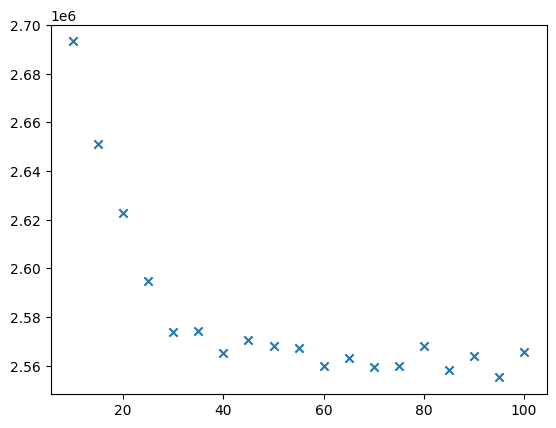

In [16]:
plt.scatter(rmsles.keys(), rmsles.values(), marker='x')
top_n = min(rmsles, key=rmsles.get)
print("Top N: ", top_n)

In [17]:
best_feats = most_important_features[:top_n]

In [22]:
best_feats = best_feats.col_name.tolist()

# Testing

In [25]:
from sklearn.model_selection import KFold

def train(X, y, evalset=None):    
    model = lgb.LGBMRegressor(**best_params)
    if not evalset:
        model.fit(X, y)
    else:
        model.fit(X, y, eval_set=evalset)

    return model

def find_best_model(processed_df):
    # Return best model from kfolds
    best_model = None
    min_loss = float('inf')
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    for fold, (train_idx, test_idx) in enumerate(cv.split(processed_df)):
        X_train = processed_df.iloc[train_idx]
        y_train = X_train["price_doc"]
        X_train.drop(["price_doc"], axis=1, inplace=True)

        X_val = processed_df.iloc[test_idx]
        y_val = X_val["price_doc"]
        X_val.drop(["price_doc"], axis=1, inplace=True)

        evalset = [(X_val, y_val)]
        model = train(X_train, y_train, evalset)

        pred = model.predict(X_val)
        loss = mean_squared_error(y_val, pred, squared=False)

        if loss < min_loss:
            min_loss = loss
            best_model = model
    
    return best_model, min_loss

In [26]:
model, loss = find_best_model(processed_df[best_feats+['price_doc']])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [27]:
print("Loss: ", loss)
pred = model.predict(processed_test_df[best_feats])

Loss:  2238795.9101208732


In [ ]:
# Save predictions
prediction_df = pd.DataFrame({
    'id': test_df['id'],
    'price_doc': pred
})

prediction_df.to_csv('./output/lgbm_pred.csv', index=False)